In [1]:
# PyTorch Modules you need for this lab

from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np


# Other non-PyTorch Modules

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

C:\Users\trist\anaconda3\envs\env_torch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\trist\anaconda3\envs\env_torch\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def show_data(data_sample, size):
    plt.imshow(data_sample[0].numpy().reshape(size, size), cmap='gray')
    plt.title(f"Real Label = {labels[data_sample[1]]}")

In [3]:
# (torch.rand(size=(5,5)) < 0.5).float()

In [4]:
class RandomSparse(object):
    """
    """

    def __init__(self):
        pass

    def __call__(self, sample):
        # image, label = sample['image'], sample['label']

        temp = (torch.rand(size=sample.shape) < 0.9).float()
        return sample*temp

        # return {'image': torch.multiply(image,temp), 'label': label}

In [5]:
from scipy.signal import convolve2d
class edge_detection_horizontal(object):
    """
    """

    def __init__(self):
        pass

    def __call__(self, sample):
        # image, label = sample['image'], sample['label']

        temp = torch.tensor([
            [-1, 0, 1],
            [-1, 0, 1],
            [-1, 0, 1]
        ])
        # print(sample)
        return torch.tensor([convolve2d(sample[0], temp, mode="same")])

In [6]:
class edge_detection_vertical(object):
    """
    """

    def __init__(self):
        pass

    def __call__(self, sample):
        # image, label = sample['image'], sample['label']

        temp = torch.tensor([
            [-1, -1, -1],
            [0, 0, 0],
            [-1, -1, -1]
        ])
        # print(sample)
        return torch.tensor([convolve2d(sample[0], temp, mode="same")])

In [7]:

IMAGE_SIZE = 64
#Generates an object to store multiple transformations

composed = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    
    transforms.ToTensor(),
    edge_detection_vertical(),
    edge_detection_horizontal()
    ])

In [8]:
#Creating the two dataset objects and applying our transformations from above

dataset_train = dsets.FashionMNIST(root= '.fashion/data', train=True, transform=composed,  download=True)
  
dataset_val = dsets.FashionMNIST(root= '.fashion/data', train=False, transform=composed,  download=True)



In [9]:
print(dataset_train)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .fashion/data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


C:\Users\trist\AppData\Local\Temp/ipykernel_17064/3068682278.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  return torch.tensor([convolve2d(sample[0], temp, mode="same")])


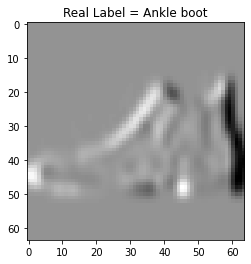

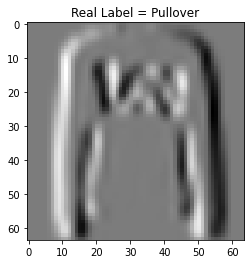

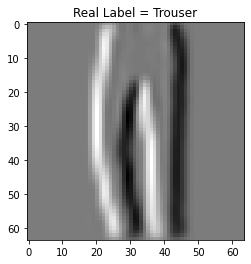

In [10]:
for n,data_sample in enumerate(dataset_val):

    show_data(data_sample, IMAGE_SIZE)
    # print(data_sample)
    plt.show()
    if n==2:
        break 

In [11]:
#Every PyTorch model must inherit from torch.nn.Module
#nn.Module has very useful functions for models
class CNN(nn.Module):
    
    # Constructor: (out_1: Output channels of first CNN Layer), (out_2: Output channels of second CNN Layer), (number_of_classes: Number of classes to detect)
    def __init__(self, out_1=16, out_2=64, number_of_classes=10):
        super().__init__()
        #Create first Convolution Layer with input of 1 channel (grayscale) and output of out_1 channels
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)

        
        


        #Create a fully connected layer for the CNN. The input shape is the flattened convolution output. If output is (3, 28, 28), input is 28 * 28 * 3.
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)

        # Prediction (x is input)
	# The forward function is automatically called when we create an instance of the class and call it.
    def forward(self, x):
        x = self.cnn1(x)
     
        
        #Flattening cnn2's output and passing it into a fully connected layer
        # x = x.view(x.size(0), -1)
        x = self.flat(x)
        x = self.fc1(x)

In [12]:
#Data Loader for training data
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100 )

#Data Loader for validation data
test_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=100 )

In [13]:
from custom_classes import Splatter

#Creating the model
model = nn.Sequential(
    Splatter(3, 3),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(3844, 10)
)

#Creating an Adam optimizer with a learning rate of 0.002
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

#Use Cross Entropy Loss since this is a classification problem
criterion = nn.CrossEntropyLoss()

In [14]:
# To show a progress bar while training
from tqdm import tqdm

training_acc_list=[]
val_acc_list=[]
N_test=len(dataset_val)
N_train = len(dataset_train)
n_epochs=5

for epoch in range(n_epochs):
    #Count how many predictions were correct
    correct = 0

    print()
    print(f"Epoch no. {epoch}")
    #Put model into training mode (uses Dropout if there are Dropout layers)
    model.train()
    #Loop over each sample in the dataloaders.
    for x, y in tqdm(train_loader):
        #Zero the optimizer gradients (PyTorch requires this.)
        optimizer.zero_grad()
        #Make a prediction
        y_hat = model(x)
        #Calculate the loss with the criterion
        loss = criterion(y_hat, y)
        #Initiate backpropagation/calculate derivatives of parameters with respect to the loss.
        loss.backward()
        #Update parameters
        optimizer.step()
        
        #Update correct counter
        #Grab the index of the AI's highest probability guess (Each output of model(x) is a tensor of probabilities) 
        correct += (torch.argmax(y_hat, 1) == y).sum().item()
        
    #Calculate accuracy
    accuracy = correct / N_train
    print("Training accuracy: " + str(accuracy))
    training_acc_list.append(accuracy)

    correct=0
    
    #Put model into validation mode (turns off Dropout if there are Dropout layers)
    model.eval()
    for x_test, y_test in test_loader:
        #Make a prediction
        z = model(x_test)
        #Grab the index of the AI's highest probability guess (Each output of model(x) is a tensor of probabilities) 
        y_hat = torch.argmax(z, 1)
        #Update correct counter if the prediction was correct
        correct += (y_hat == y_test).sum().item()
    accuracy = correct / N_test
    print("Validation accuracy: " + str(accuracy))
    val_acc_list.append(accuracy)


Epoch no. 0


  5%|▌         | 32/600 [00:04<01:13,  7.72it/s]


KeyboardInterrupt: 